# Data loading

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
DATA_FOLDER = '../data'

## Patients metadata
Contains target variable as well personal data - age, sex.

We have 190 samples - 90 healthy + 100 patients.

In [3]:
df_patients = pd.read_csv(f'{DATA_FOLDER}/patients-metadata.csv')

In [4]:
print(df_patients.shape, df_patients.columns)
df_patients.head(2)

(190, 4) Index(['folder', 'personal code (Hydra ID)', 'age', 'sex (1=M)'], dtype='object')


,folder,personal code (Hydra ID),age,sex (1=M)
0,ESO_C10006_20100723_1339_1,10006,24.750,2
1,ESO_C10013_20100715_1534_1,10013,27.667,2


In [5]:
df_patients['target'] = df_patients.apply(lambda x: 1 if x.folder.startswith('ESO_P') else 0, axis=1)

In [6]:
df_patients['target'].value_counts()

1    100
0     90
Name: target, dtype: int64

In [7]:
df_patients.drop(columns=['folder', 'personal code (Hydra ID)'], inplace=True)

In [8]:
df_patients.rename({'sex (1=M)' : 'sex'}, axis=1, inplace=True)

In [9]:
df_patients.sex = df_patients.sex - 1

In [10]:
df_patients.head()

,age,sex,target
0,24.750,1,0
1,27.667,1,0
2,34.167,1,0
3,28.917,1,0
4,31.917,0,0


In [11]:
patients = (df_patients["target"] == 1)
men = (df_patients["sex"] == 0)
print(f"Patients: {sum(patients)} ({sum(patients) / len(patients) * 100:.2f} %) (men: {sum(patients & men)}, women: {sum(patients & ~men)})")
print(f"Healthy: {sum(~patients)} ({sum(~patients) / len(patients) * 100:.2f} %) (men: {sum(~patients & men)}, women: {sum(~patients & ~men)})")

Patients: 100 (52.63 %) (men: 58, women: 42)
Healthy: 90 (47.37 %) (men: 40, women: 50)


In [12]:
print(f"Patients age: {df_patients[patients]['age'].mean():.2f} (men: {df_patients[patients & men]['age'].mean():.2f}, women: {df_patients[patients & ~men]['age'].mean():.2f})")
print(f"Patients age: {df_patients[patients]['age'].std():.2f} (men: {df_patients[patients & men]['age'].std():.2f}, women: {df_patients[patients & ~men]['age'].std():.2f})")
print("====")
print(f"Healthy age: {df_patients[~patients]['age'].mean():.2f} (men: {df_patients[~patients & men]['age'].mean():.2f}, women: {df_patients[~patients & ~men]['age'].mean():.2f})")
print(f"Healthy age: {df_patients[~patients]['age'].std():.2f} (men: {df_patients[~patients & men]['age'].std():.2f}, women: {df_patients[~patients & ~men]['age'].std():.2f})")

Patients age: 28.75 (men: 26.57, women: 31.75)
Patients age: 6.83 (men: 5.13, women: 7.75)
====
Healthy age: 27.81 (men: 28.15, women: 27.54)
Healthy age: 6.82 (men: 6.90, women: 6.82)


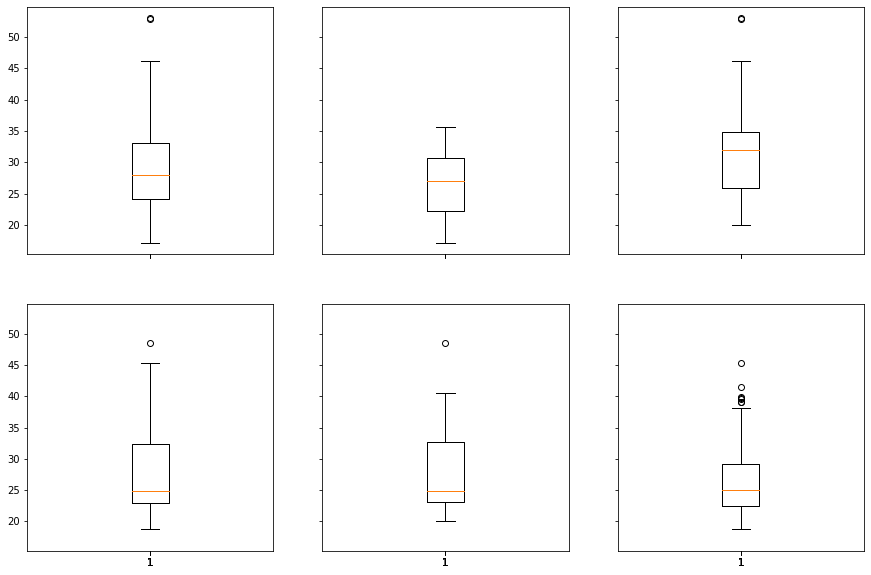

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10), sharey=True, sharex=True)
_ = ax[0][0].boxplot(df_patients[patients]["age"])
_ = ax[0][1].boxplot(df_patients[patients & men]["age"])
_ = ax[0][2].boxplot(df_patients[patients & ~men]["age"])
_ = ax[1][0].boxplot(df_patients[~patients]["age"])
_ = ax[1][1].boxplot(df_patients[~patients & men]["age"])
_ = ax[1][2].boxplot(df_patients[~patients & ~men]["age"])

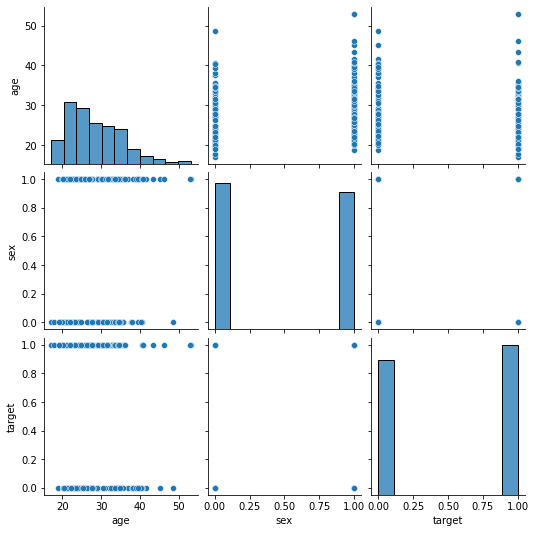

In [14]:
sns.pairplot(df_patients)

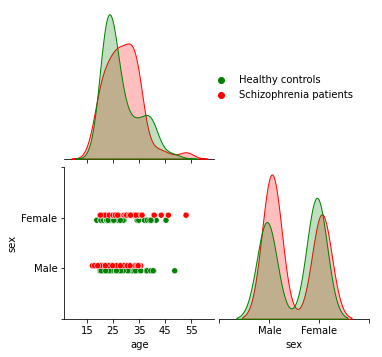

In [15]:
df_patients_adj = df_patients.copy(deep=True)
def adjust_sex(sex, target):
    return sex - 0.05 if target == 0 else sex + 0.05
df_patients_adj["sex"] = df_patients_adj.apply(lambda x: adjust_sex(x["sex"], x["target"]), axis=1)

fig = sns.pairplot(df_patients_adj, hue="target", corner=True, palette={0: "g", 1: "r"})
fig._legend.set_title("")
new_labels = ['label 1', 'label 2']
for t, l in zip(fig._legend.texts, ['Healthy controls', 'Schizophrenia patients']):
    t.set_text(l)
fig._legend.set_bbox_to_anchor((0.9, 0.75))

fig.axes.flat[3].set_yticks([-1, 0, 1, 2])
fig.axes.flat[3].set_yticklabels(["","Male", "Female",""])

fig.axes.flat[2].set_xticks(list(range(15, 60, 10)))
fig.axes.flat[2].set_xticklabels(list(range(15, 60, 10)))

fig.axes.flat[3].set_xticks([-1, 0, 1, 2])
_ = fig.axes.flat[3].set_xticklabels(["","Male", "Female",""])

# fig.savefig("dataset-pairplot.pdf")

In [16]:
# df_patients.to_csv(f'{DATA_FOLDER}/patients-cleaned.csv')

## Timeseries data

For each patient one time series per brain region is available.

That means we have 90 regions, each has 400 long time series per subject.

In [17]:
import scipy.io
matlab_file = scipy.io.loadmat(f'{DATA_FOLDER}/eso190_aal_strin_090_avg.mat')

In [18]:
np_timeseries = matlab_file['subj_tcs']

In [19]:
np_timeseries.shape

(400, 90, 190)

In [20]:
np_timeseries = np_timeseries.transpose(2, 1, 0)
np_timeseries.shape

(190, 90, 400)

In [21]:
import pickle

# with open('../data/timeseries.pickle', 'wb') as f:
#     pickle.dump(np_timeseries, f)

with open('../data/timeseries.pickle', 'rb') as f:
    ts = pickle.load(f)

# Plot timeseries

In [22]:
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
def plot_ts(subject, region):
    data = ts[subject, region, :]
    plt.plot(range(data.shape[-1]), data)
    plt.title(f"Region [{region}], Subject [{subject}] - {'control' if subject < 90 else 'patient'}")
    plt.show()

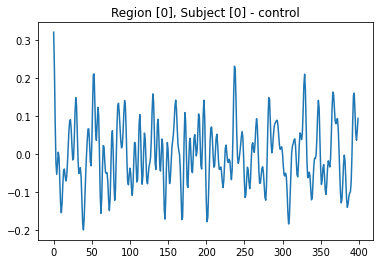

In [24]:
plot_ts(0, 0)

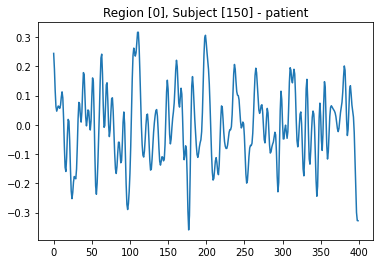

In [30]:
plot_ts(150, 0)

## Timeseries histogram

In [37]:
def plot_ts_histogram(subject, region, bins=70):
    data = ts[subject, region, :]
    plt.hist(data, bins=bins, alpha=0.5)
    plt.axvline(np.mean(data), c='k')
    plt.axvline(np.mean(data) + np.std(data), c='r')
    plt.axvline(np.mean(data) - np.std(data), c='r')
    plt.xlim([-0.5, 0.5])   # Fix for easier eye inspection.
    plt.title(f"Region [{region}], Subject [{subject}] - {'control' if subject < 90 else 'patient'}")
    plt.show()

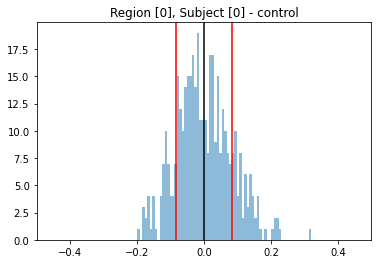

In [38]:
plot_ts_histogram(0,0)

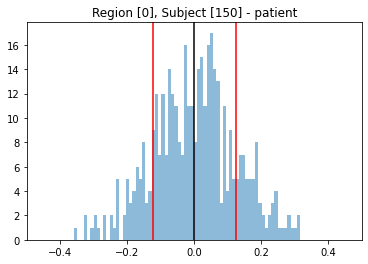

In [39]:
plot_ts_histogram(150,0)